# Predicting AAPL Price Volatility and Deriving Trade Signals

## Part 1: Importing Libraries and Data Cleaning

In this section, we import the necessary Python libraries and connect to the **Polygon.io API** to retrieve historical stock data for **AAPL (Apple Inc.)**.  
The Polygon API provides high-resolution financial market data, including open, high, low, close (OHLC) prices and trading volume.  
We’ll use this data as the foundation for our volatility analysis and model training in later sections.

In [41]:
import pandas as pd
import requests
url = f"https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/minute/2025-01-09/2025-02-10?apiKey=vFDjkUVRfPnedLrbRjm75BZ9CJHz3dfv"
response = requests.get(url)
data = response.json()

Here, we take Polygon's raw JSON response and convert it into a clean, time-stamped Pandas DataFrame.

In [42]:
if 'results' in data:
    df = pd.DataFrame(data['results'])
else:
    raise ValueError("No data returned from Polygon API")

# Convert timestamp
df['t'] = pd.to_datetime(df['t'], unit='ms')
df = df.rename(columns={'t': 'timestamp', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'})
df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

print(df.head())

            timestamp    open    high     low   close  volume
0 2025-01-10 09:00:00  243.44  244.00  241.70  242.27  4980.0
1 2025-01-10 09:01:00  242.15  242.15  241.88  241.88  1030.0
2 2025-01-10 09:02:00  242.06  242.12  242.06  242.12  1191.0
3 2025-01-10 09:04:00  242.17  242.17  242.13  242.13   644.0
4 2025-01-10 09:07:00  242.28  242.28  242.28  242.28   133.0


## Part 2: Volatility Calculation and Model Building

The code below transforms raw price data into a few financial features: returns, volatility, and moving averages. These can be used to analyze market behavior and train a predictive model.

In [43]:
df['return'] = df['close'].pct_change()

df['volatility'] = df['return'].rolling(window=30).std()

df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_50'] = df['close'].rolling(window=50).mean()

df = df.dropna()

Here, we'll shift the data so our model can learn to predict future volatility

In [ ]:
df['target_volatility'] = df['volatility'].shift(-1)
df = df.dropna()

Assigning features and target variables:

In [45]:
features = ['return', 'sma_10', 'sma_50']
X = df[features]
y = df['target_volatility']

## Part 3: Model Building

In this section, we train a **Random Forest Classifier** to predict whether future volatility will be **high or low** based on current market features.
We use a Random Forest because it’s a strong, flexible model that can find patterns in the data without much tuning. It works well with noisy financial data, avoids overfitting, and gives reliable results for classification tasks like this.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

## Part 4: Model Evaluation and Conclusion
Now, we'll evaluate our model's performance on the data.

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_test and y_pred are defined
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.000223
Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000402
R-squared (R²): 0.0341


The model's predictions are numerically close to the actual volatility values (small MAE, small RMSE). However, the low R^2 value indicates that the model explains only about 3 percent of the variation in true volatility. Furthermore, while predictions are generally near the correct scale, the model struggles to capture meaningful patterns in volatility over time.

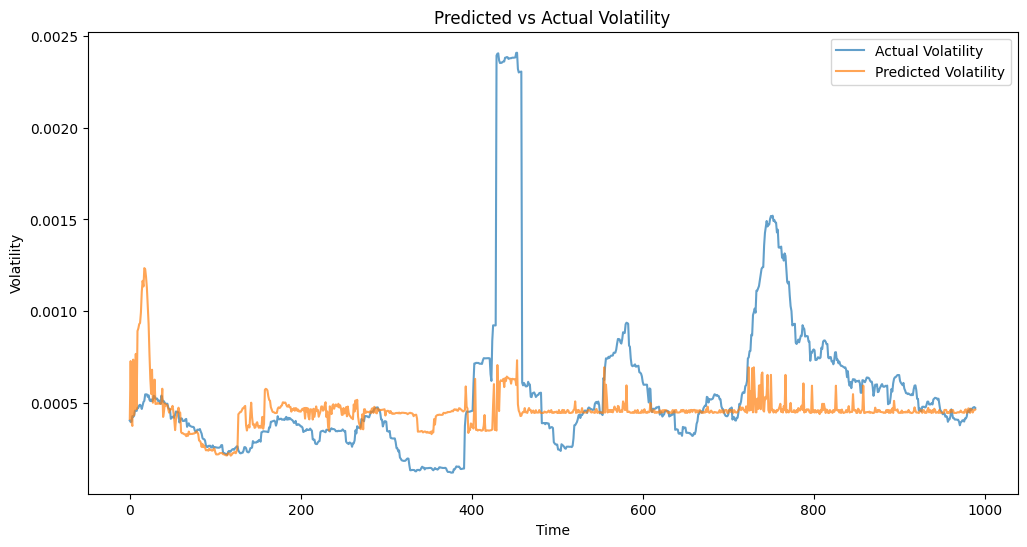

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Volatility', alpha=0.7)
plt.plot(y_pred, label='Predicted Volatility', alpha=0.7)
plt.title("Predicted vs Actual Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

Based on the plot, the model tracks actual volatility reasonably well during low-volatility periods. However, it critically fails to predict large spikes, completely missing the major event around time 410 and severely underestimating the magnitude of other spikes (e.g., around 750). The predictions are too "smooth" and do not capture the true range of market risk, making the model unreliable for forecasting extreme events.

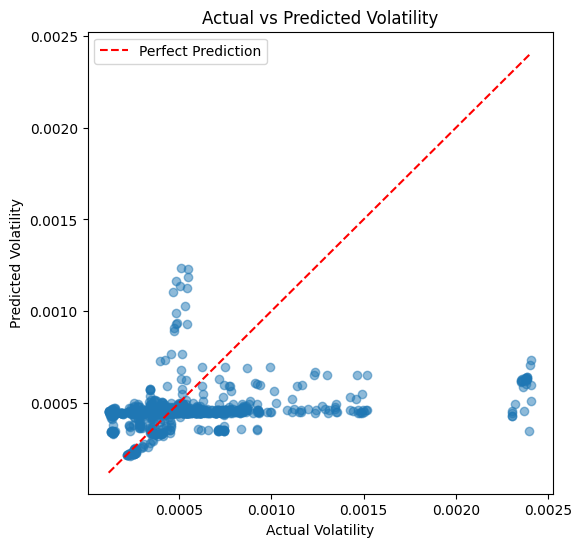

In [49]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title("Actual vs Predicted Volatility")
plt.xlabel("Actual Volatility")
plt.ylabel("Predicted Volatility")
plt.legend()
plt.show()


This scatter plot confirms our findings from the time-series chart. Ideally all points fall on red line. However, this chart shows that our model underperforms for larger volatilities.